# Kaggle competition project

This project is a kaggle competition project, taking part on the 'calories prediction' competition, so I am using a mock dataset, provided by kaggle. I am creating this project with the aim of training the development of a project and will be deployed later on kaggle.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


In [4]:
train = pd.read_csv("./Data/train.csv")
test = pd.read_csv("./Data/test.csv")
submission = pd.read_csv("./Data/sample_submission.csv")

In [5]:
train.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [6]:
test.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,750000,male,45,177.0,81.0,7.0,87.0,39.8
1,750001,male,26,200.0,97.0,20.0,101.0,40.5
2,750002,female,29,188.0,85.0,16.0,102.0,40.4
3,750003,female,39,172.0,73.0,20.0,107.0,40.6
4,750004,female,30,173.0,67.0,16.0,94.0,40.5


#### EDA - Cleaning the data and adjusting the dataset

In [7]:
train['Sex'] = train['Sex'].map({'male': 1, 'female': 0})
test['Sex'] = test['Sex'].map({'male': 1, 'female': 0})

In [8]:
train = train.drop_duplicates(subset=train.columns).reset_index(drop=True)

In [9]:
train = train.groupby(['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp'])['Calories'].min().reset_index()

In [10]:
train.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,20,135.0,51.0,14.0,94.0,40.1,67.0
1,0,20,136.0,45.0,1.0,90.0,37.8,5.0
2,0,20,141.0,49.0,26.0,101.0,40.8,151.0
3,0,20,141.0,52.0,18.0,106.0,40.1,111.0
4,0,20,142.0,48.0,1.0,79.0,37.7,4.0


Correlation heatmap and distribution

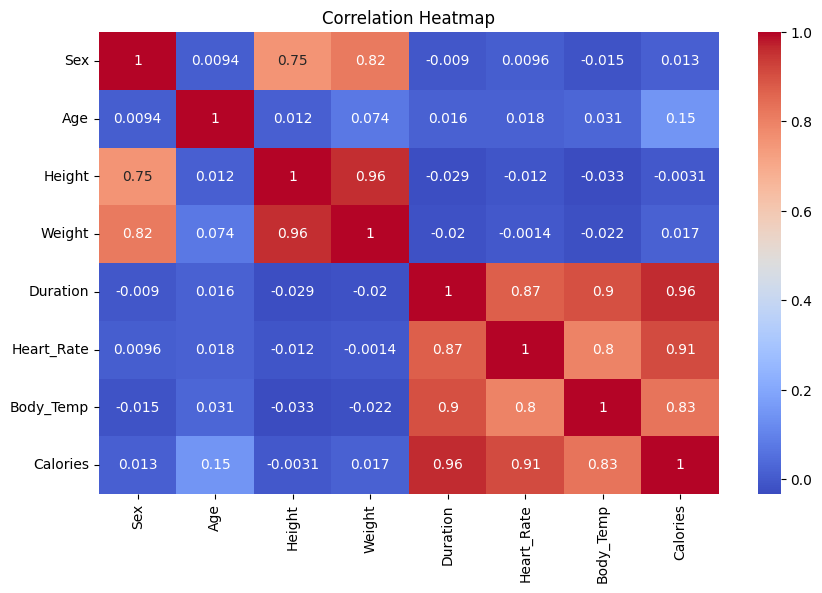

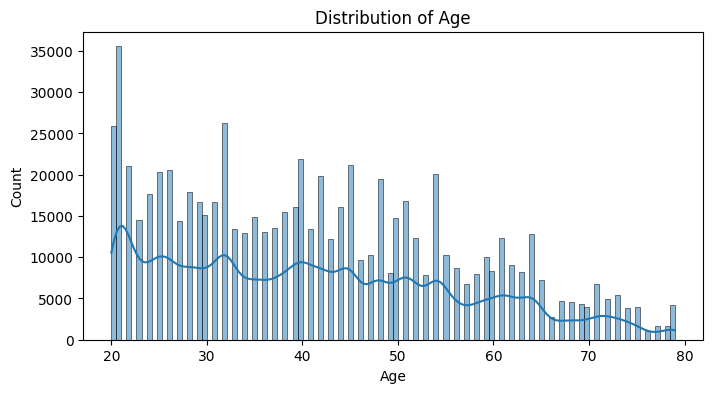

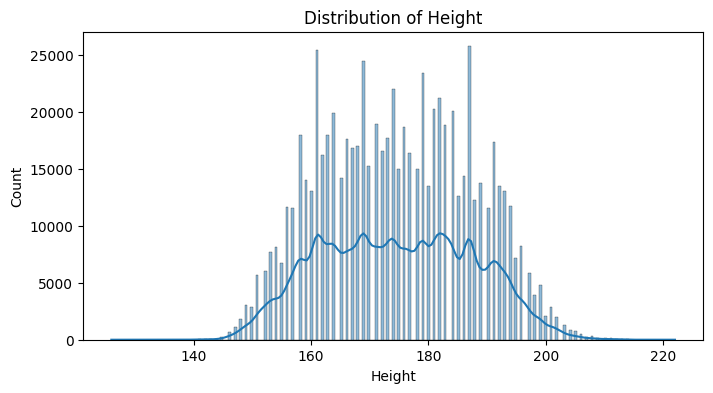

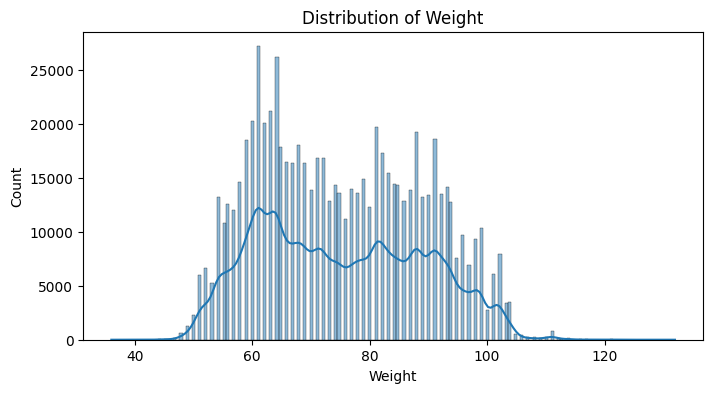

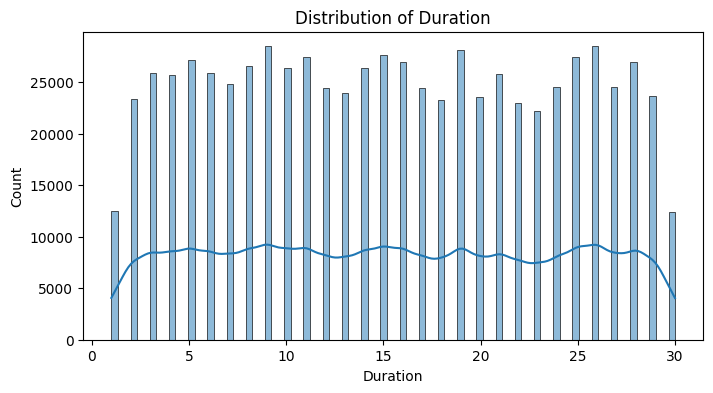

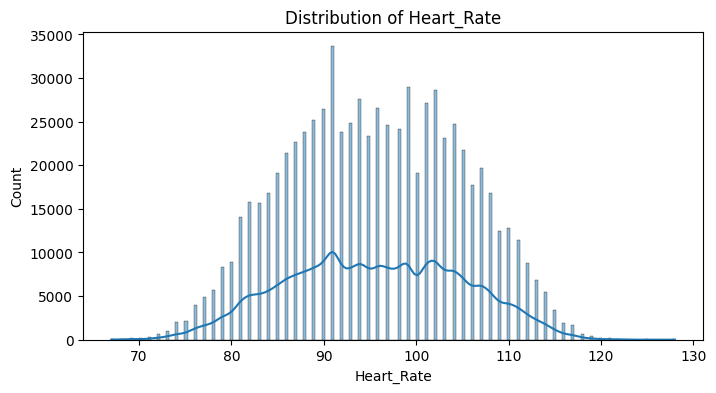

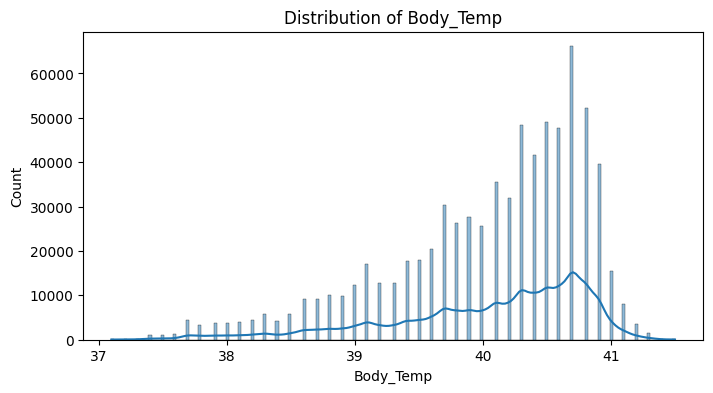

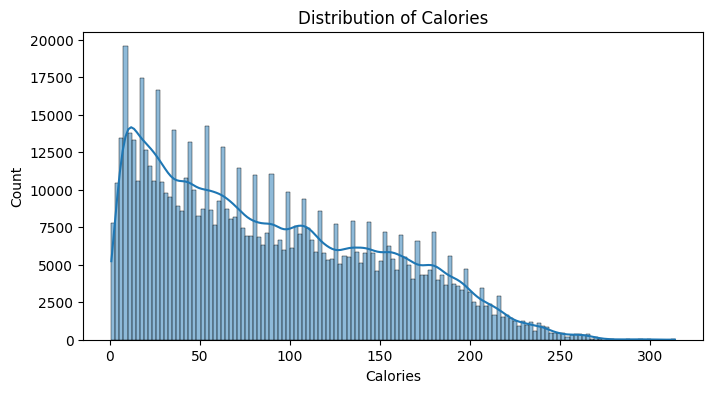

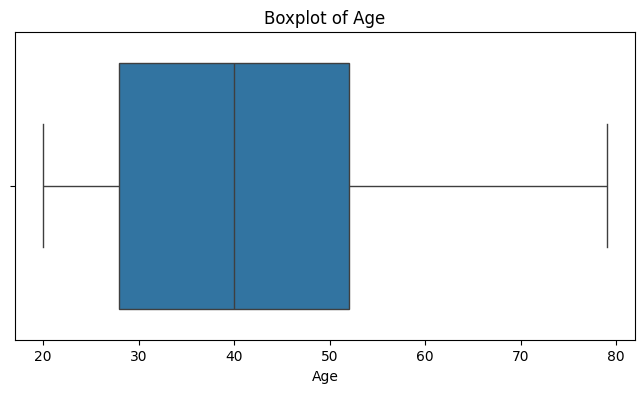

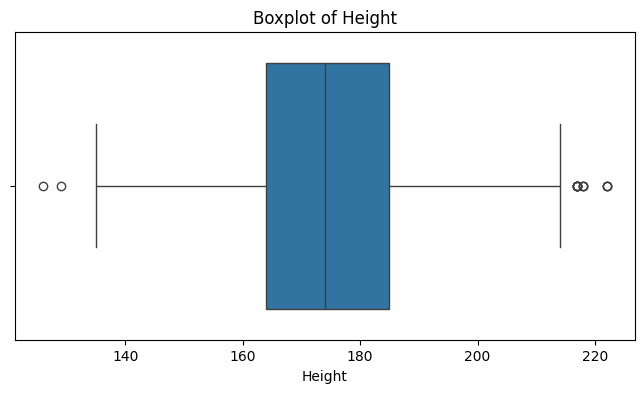

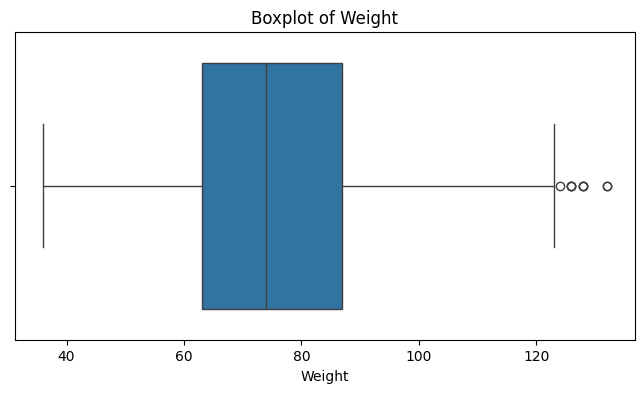

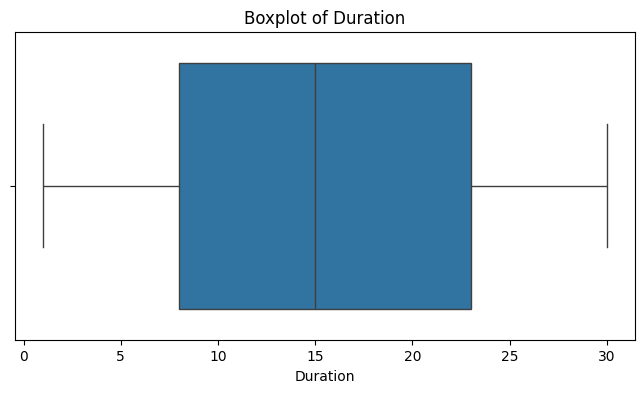

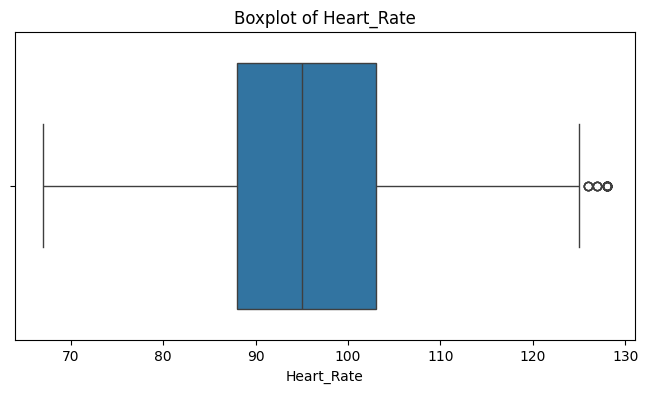

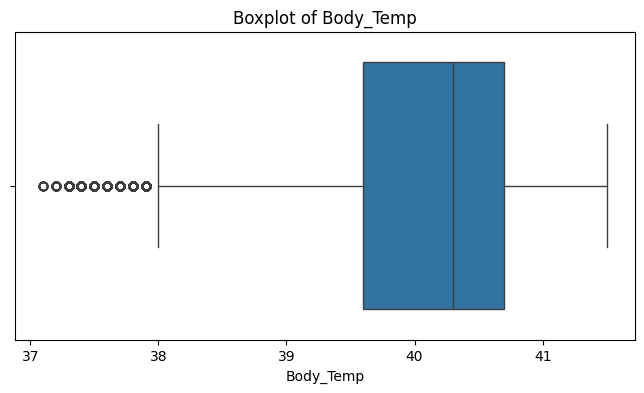

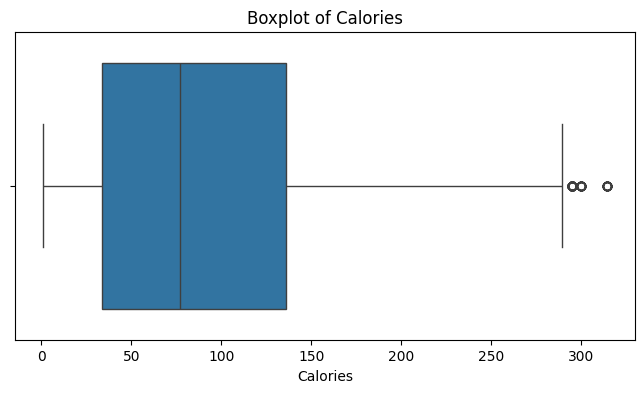

In [12]:
plt.figure(figsize=(10, 6))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

features = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Calories']
for col in features:
    plt.figure(figsize=(8, 4))
    sns.histplot(train[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

for col in features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=train[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

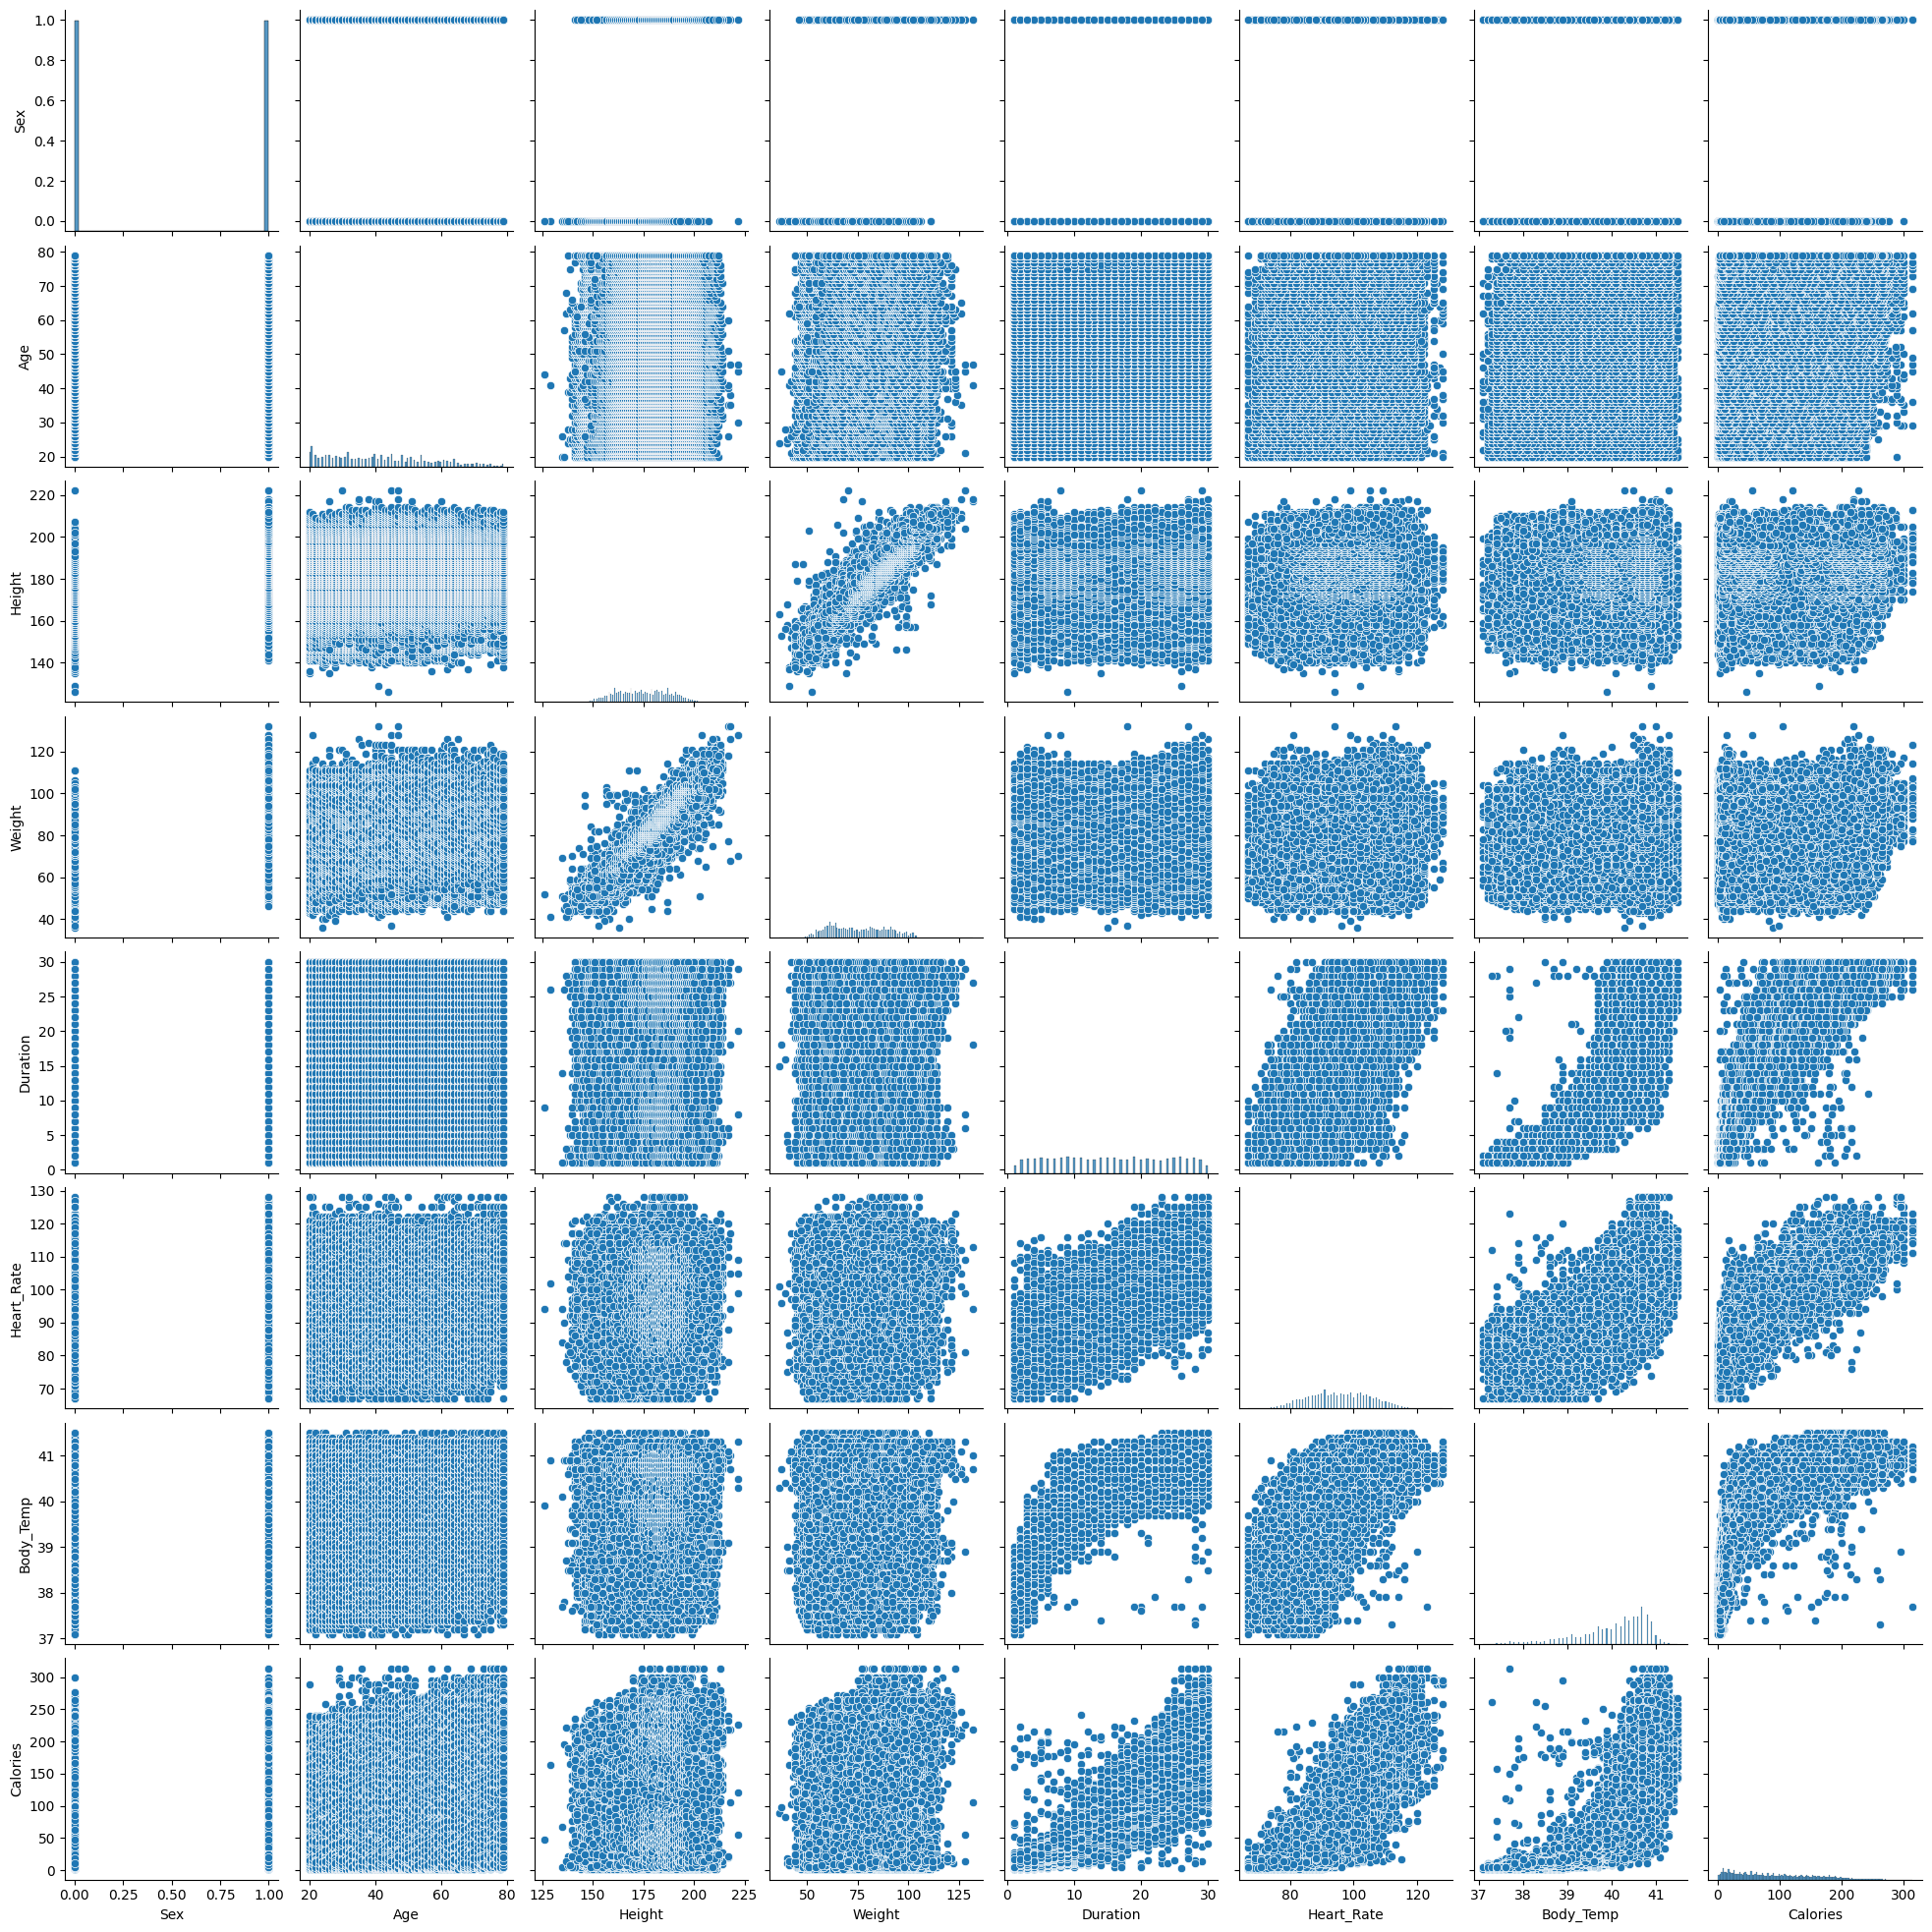

In [18]:
sns.pairplot(train)


In [13]:
df = train.copy()

BMI is an indicator that calculates the weight divided by the height squared. It's used to estimate the quantity of body fat. And intensity is a form of calculate the intensity of the physical activity, so we are going to insert those metrics and check the correlation between those indicators.

In [15]:
df['BMI'] = df['Weight'] / (df['Height'] / 100) ** 2
df['Intensity'] = df['Heart_Rate'] / df['Duration']

In [16]:
df

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,BMI,Intensity
0,0,20,135.0,51.0,14.0,94.0,40.1,67.0,27.983539,6.714286
1,0,20,136.0,45.0,1.0,90.0,37.8,5.0,24.329585,90.000000
2,0,20,141.0,49.0,26.0,101.0,40.8,151.0,24.646648,3.884615
3,0,20,141.0,52.0,18.0,106.0,40.1,111.0,26.155626,5.888889
4,0,20,142.0,48.0,1.0,79.0,37.7,4.0,23.804801,79.000000
...,...,...,...,...,...,...,...,...,...,...
742153,1,79,207.0,102.0,3.0,94.0,38.9,20.0,23.804523,31.333333
742154,1,79,207.0,119.0,26.0,109.0,41.0,246.0,27.771943,4.192308
742155,1,79,209.0,75.0,21.0,102.0,40.2,175.0,17.169937,4.857143
742156,1,79,211.0,111.0,24.0,95.0,40.7,176.0,24.932055,3.958333


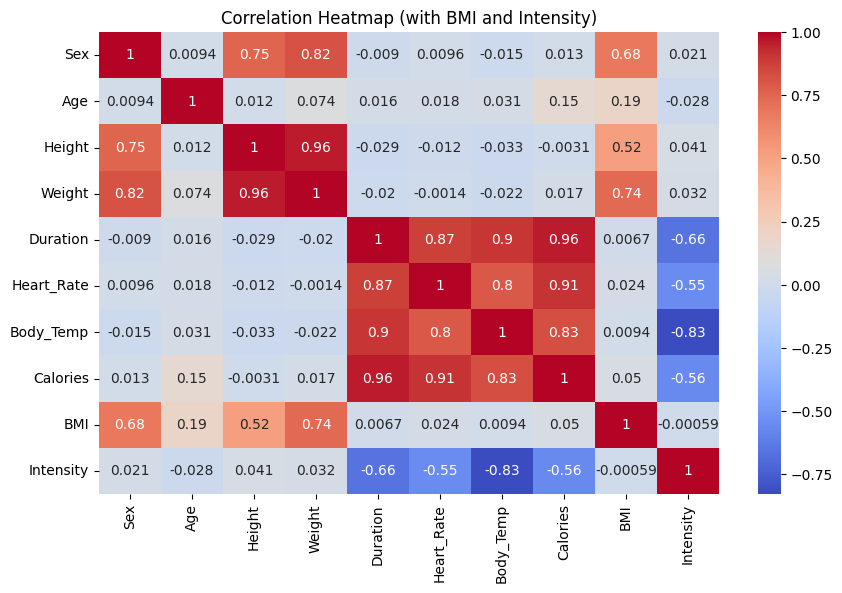

In [20]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap (with BMI and Intensity)')
plt.show()

In [22]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [25]:
X = df.drop(columns=['Calories'])
y = df['Calories']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Training XGBOOST REGRESSOR

In [27]:
xgb = XGBRegressor(random_state=42)

param_grid = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.01, 0.05],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid,
                           cv=3,scoring='neg_root_mean_squared_error', verbose=2)

grid_search.fit(X_train, y_train)

print('XGB best parameters:', grid_search.best_params_)
print('XGB best RMSE :', -grid_search.best_score_)
best_params = grid_search.best_params_
xgb = XGBRegressor(**best_params, random_state=42)
xgb.fit(X_train, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.8; total time=   6.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.8; total time=   6.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.8; total time=   6.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=1.0; total time=   3.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=1.0; total time=   3.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=1.0; total time=   3.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.8; total time=  13.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.8; total time=  16.8s
[CV] END 

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

After training and evaluate the XGB and LGB, I went for kaggle competition hub, and checked on other code competitors code. No competitors used normalization on data, they only used other forms of feature engeneering.